# OverView

Five times more deadly than the flu, COVID-19 causes significant morbidity and mortality. Like other pneumonias, pulmonary infection with COVID-19 results in inflammation and fluid in the lungs. COVID-19 looks very similar to other viral and bacterial pneumonias on chest radiographs, which makes it difficult to diagnose. Your computer vision model to detect and localize COVID-19 would help doctors provide a quick and confident diagnosis. As a result, patients could get the right treatment before the most severe effects of the virus take hold.

Currently, COVID-19 can be diagnosed via polymerase chain reaction to detect genetic material from the virus or chest radiograph. However, it can take a few hours and sometimes days before the molecular test results are back. By contrast, chest radiographs can be obtained in minutes. While guidelines exist to help radiologists differentiate COVID-19 from other types of infection, their assessments vary. In addition, non-radiologists could be supported with better localization of the disease, such as with a visual bounding box.

As the leading healthcare organization in their field, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation. SIIM has partnered with the Foundation for the Promotion of Health and Biomedical Research of Valencia Region (FISABIO), Medical Imaging Databank of the Valencia Region (BIMCV) and the Radiological Society of North America (RSNA) for this competition.

In this competition, you’ll identify and localize COVID-19 abnormalities on chest radiographs. In particular, you'll categorize the radiographs as negative for pneumonia or typical, indeterminate, or atypical for COVID-19. You and your model will work with imaging data and annotations from a group of radiologists.

If successful, you'll help radiologists diagnose the millions of COVID-19 patients more confidently and quickly. This will also enable doctors to see the extent of the disease and help them make decisions regarding treatment. Depending upon severity, affected patients may need hospitalization, admission into an intensive care unit, or supportive therapies like mechanical ventilation. As a result of better diagnosis, more patients will quickly receive the best care for their condition, which could mitigate the most severe effects of the virus.

## 1- Loading Libraries

In [1]:
!pip install pandas numpy pillow tqdm pydicom python-gdcm ultralytics pylibjpeg-libjpeg

In [5]:
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
import pydicom
#The pydicom.pixels.apply_voi_lut function is used in medical imaging to apply a "Value of Interest Lookup Table" (VOI LUT) to DICOM images. In the context of Digital Imaging and Communications in Medicine (DICOM) files, this function helps adjust image contrast and brightness to make specific details in the image more visible, which is particularly useful in diagnostic imaging.
from pydicom.pixel_data_handlers.util import apply_voi_lut

## 2- Reading Dicom files and convert it to jpeg image

In [3]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.dcmread(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [4]:
train = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')

In [5]:
image_id = []
dim0 = []
dim1 = []
splits = []
jpg_path = "/kaggle/tmp/siim-covid19-detection_jpg"
os.makedirs(jpg_path, exist_ok=True)
for split in ['test', 'train']:
    save_dir = f'{jpg_path}/{split}'
    os.makedirs(save_dir, exist_ok=True)
    
    for dirname, _, filenames in tqdm(os.walk(f'../input/siim-covid19-detection/{split}')):
        for file in filenames:
            # set keep_ratio=True to have original aspect ratio
            xray = read_xray(os.path.join(dirname, file))
            im = Image.fromarray(xray)
            im.save(os.path.join(save_dir, file.replace('dcm', 'jpg')))

            image_id.append(file.replace('.dcm', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])
            splits.append(split)

2475it [05:09,  7.99it/s]
9235it [20:31,  9.66it/s]/opt/conda/lib/python3.10/site-packages/pydicom/pixels/decoders/base.py:814: UserWarning: The pixel data is 13262360 bytes long, which indicates it contains 216296 bytes of excess padding to be removed
  warn_and_log(
12386it [27:09,  7.60it/s]


In [6]:
%%time
!tar -zcf train.tar.gz -C "/kaggle/tmp/siim-covid19-detection_jpg/train/" .
!tar -zcf test.tar.gz -C "/kaggle/tmp/siim-covid19-detection_jpg/test/" .

CPU times: user 2.56 s, sys: 588 ms, total: 3.15 s
Wall time: 3min 45s


In [7]:
df = pd.DataFrame.from_dict({'image_id': image_id, 'dim0': dim0, 'dim1': dim1, 'split': splits})
df.to_csv('meta.csv', index=False)

In [8]:
!mkdir /kaggle/working/covid_19_rsna
!mkdir /kaggle/working/covid_19_rsna/train
!mv test.tar.gz /kaggle/working/covid_19_rsna
!mv meta.csv /kaggle/working/covid_19_rsna
!mv train.tar.gz /kaggle/working/covid_19_rsna/train
!tar -zxf /kaggle/working/covid_19_rsna/train/train.tar.gz -C /kaggle/working/covid_19_rsna/train/

## 3- Load Dataset

In [6]:
from pathlib import Path

In [7]:
TRAIN_DATA_PATH = Path("/kaggle/working/covid_19_rsna/train")
META_PATH = Path("/kaggle/working/covid_19_rsna/meta.csv")
LABEL_PATH = Path("/kaggle/input/siim-covid19-detection/train_image_level.csv")

In [8]:
meta_df = pd.read_csv(META_PATH)
meta_df = meta_df[meta_df['split']=="train"]
meta_df.rename({"image_id":"id"}, axis=1, inplace=True)
meta_df.head()

id  dim0  dim1  split
1263  d8ba599611e5  2336  2836  train
1264  29b23a11d1e4  3488  4256  train
1265  8174f49500a5  2330  2846  train
1266  d54f6204b044  2330  2846  train
1267  d51cadde8626  3488  4256  train

In [9]:
label_df = pd.read_csv(LABEL_PATH)
label_df['id'] = label_df['id'].str.replace("_image", "")
label_df.head()

id                                              boxes  \
0  000a312787f2  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f                                                NaN   
2  0012ff7358bc  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                     none 1 0 0 1 1     ff0879eb20ed  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e

In [10]:
label_df = label_df.merge(meta_df, on='id',how="left")

In [11]:
label_df['image_level'] = label_df.apply(lambda row: row.label.split(' ')[0], axis=1)
label_df.head()

id                                              boxes  \
0  000a312787f2  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f                                                NaN   
2  0012ff7358bc  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  dim0  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  3488   
1                                     none 1 0 0 1 1     ff0879eb20ed  2320   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  2544   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  3520   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e  2800   

   dim1  split image_level  
0  4256  train     opacity  
1  2832  train        none  
2  3056  train     opacity  
3  4280  train     opacity  
4  3408  train     opacity

**convert bbox string of list into list**

In [12]:
import ast
label_df['boxes'] = label_df['boxes'].apply(lambda boxes: ast.literal_eval(boxes) if boxes is not np.nan else boxes)

In [13]:
print(f'Number of unique image in training dataset: {len(label_df)}')

bbox_nan_num = label_df['boxes'].isna().sum()
print(f'Number of images without any bbox annotation: {bbox_nan_num}')

Number of unique image in training dataset: 6334
Number of images without any bbox annotation: 2040


## 4- Visualization

In [14]:
!pip install opencv-python

In [15]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [16]:
def convert_bbox(x, y, width, height):
    x_min = x
    x_max = x + width
    y_min = y
    y_max = y + height
    return int(x_min), int(x_max), int(y_min), int(y_max)

In [17]:
sample = label_df.iloc[0,:]
image = cv2.imread(f"{TRAIN_DATA_PATH/sample['id']}.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = [convert_bbox(x=bbox['x'], y=bbox['y'], width=bbox['width'], height=bbox['height']) for bbox in sample['boxes']]

In [18]:
for box in bboxes:
    cv2.rectangle(image, (box[0], box[2]), (box[1], box[3]), (255, 0, 0), thickness=5)

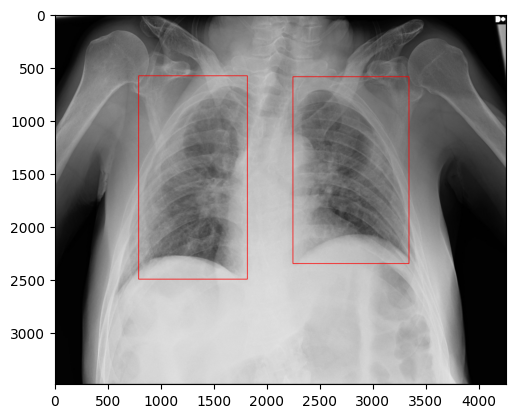

In [19]:
plt.imshow(image)

## 5- Split data into train, val split

In [ ]:
!pip install -U scikit-learn

In [20]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(label_df, test_size=0.2, random_state=42, stratify=label_df.image_level.values)

train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'

df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In [21]:
print(f'Size of dataset: {len(df)}, training images: {len(train_df)}. validation images: {len(valid_df)}')

Size of dataset: 6334, training images: 5067. validation images: 1267


## 6- Prepare Folders and files for Yolo11

In [22]:
"""
/parent_folder
    /dataset
         /images
             /train
             /val
         /labels
             /train
             /val
    /yolov11
"""

'\n/parent_folder\n    /dataset\n         /images\n             /train\n             /val\n         /labels\n             /train\n             /val\n    /yolov11\n'

In [23]:
os.makedirs('tmp/covid/images/train', exist_ok=True)
os.makedirs('tmp/covid/images/valid', exist_ok=True)

os.makedirs('tmp/covid/labels/train', exist_ok=True)
os.makedirs('tmp/covid/labels/valid', exist_ok=True)

! ls tmp/covid/images

train  valid


In [24]:
# Move the images to relevant split folder.
from shutil import copyfile

for i in tqdm(range(len(df))):
    row = df.loc[i]
    if row.split == 'train':
        copyfile(f'{TRAIN_DATA_PATH / row.id}.jpg', f'tmp/covid/images/train/{row.id}.jpg')
    else:
        copyfile(f'{TRAIN_DATA_PATH / row.id}.jpg', f'tmp/covid/images/valid/{row.id}.jpg')

100%|██████████| 6334/6334 [00:04<00:00, 1307.52it/s]


#### Create .Yaml file

an "optional" download command/URL for auto-downloading,
1. a path to a directory of training images (or path to a *.txt file with a list of training images),
2. a path to a directory of validation images (or path to a *.txt file with a list of validation images),
3. the number of classes,
4. a list of class names.

In [25]:
import yaml

data_yaml = dict(
    train = 'covid/images/train',
    val = 'covid/images/valid',
    nc = 2,
    names = ['none', 'opacity']
)
with open('tmp/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
%cat tmp/data.yaml

{names: [none, opacity], nc: 2, train: covid/images/train, val: covid/images/valid}


#### Prepare Bounding Box Coordinated for Yolo11

For every image with bounding box(es) a .txt file with the same name as the image will be created in the format shown below:

* One row per object.
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). We can normalize by the boxes in pixels by dividing x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

In [ ]:
def convert_to_yolo_format(label, image_width, image_height):
    yolo_labels = []

    # Check if the label contains "none", skip if no objects
    if label.startswith("none"):
        return []  # Return empty if no objects

    # Split the label into bounding box groups
    objects = label.split("opacity")[1:]  # Use the class name to split for each object ['1 x1 y1 width height', '1 x1 y1 width height']
    
    for obj in objects:
        # Extract bounding box coordinates and class (assuming 1 for opacity)
        obj = obj.strip().split()  # Split each object's components
        confidence, x1, y1, box_width, box_height = map(float, obj)

        # Calculate YOLO format values (class, x_center, y_center, width, height)
        x_center = (x1 + box_width / 2) / image_width
        y_center = (y1 + box_height / 2) / image_height
        width = box_width / image_width
        height = box_height / image_height

        # Append the class label (1 for opacity) and bounding box in YOLO format
        yolo_labels.append(f"1 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_labels

In [27]:
# Prepare the txt files for bounding box
for i in tqdm(range(len(df))):
    row = df.loc[i]
    # Get image id
    img_id = row.id
    # Get split
    split = row.split
    # Get image-level label
    label = row.image_level
    
    if row.split=='train':
        file_name = f'tmp/covid/labels/train/{row.id}.txt'
    else:
        file_name = f'tmp/covid/labels/valid/{row.id}.txt'
        
    
    if label=='opacity':
        # Format for YOLOv11
        yolo_bboxes = convert_to_yolo_format(row.label, row.dim0, row.dim1)
        
        with open(file_name, 'w') as f:
            for bbox in yolo_bboxes:
                f.write(bbox)
                f.write('\n')

100%|██████████| 6334/6334 [00:01<00:00, 3857.55it/s]


## 7- Yolo11 Training

In [14]:
!pip install ultralytics

In [55]:
from ultralytics import YOLO
import warnings
warnings.filterwarnings("ignore")

model = YOLO("/kaggle/working/runs/detect/train3/weights/best.pt")  # load a pretrained model (recommended for training)
train_results = model.train(data="/kaggle/working/tmp/data.yaml", epochs=50, imgsz=640, device="0,1")

Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train3/weights/best.pt, data=/kaggle/working/tmp/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0,1, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning /kaggle/working/tmp/covid/labels/train.cache... 3435 images, 1632 backgrounds, 241 corrupt: 100%|██████████| 5067/5067 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/tmp/covid/images/train/001bd15d1891.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0393]
train: WARNING ⚠️ /kaggle/working/tmp/covid/images/train/0060e4f54aa8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0517]
train: WARNING ⚠️ /kaggle/working/tmp/covid/images/train/007cf31356c6.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0466]
train: WARNING ⚠️ /kaggle/working/tmp/covid/images/train/0133bf9a5f5c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0435]
train: WARNING ⚠️ /kaggle/working/tmp/covid/images/train/015ac3c7199d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0006]
train: WARNING ⚠️ /kaggle/working/tmp/covid/images/train/01c6d2e4f936.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0375]
train: WARNING ⚠️ /kag

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/tmp/covid/labels/valid.cache... 859 images, 408 backgrounds, 60 corrupt: 100%|██████████| 1267/1267 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: WARNING ⚠️ /kaggle/working/tmp/covid/images/valid/00e37a390f0f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.012]
val: WARNING ⚠️ /kaggle/working/tmp/covid/images/valid/041c956d9bd7.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0849]
val: WARNING ⚠️ /kaggle/working/tmp/covid/images/valid/0b9ceba31ef2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0217]
val: WARNING ⚠️ /kaggle/working/tmp/covid/images/valid/0da9fb01f04a.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0306]
val: WARNING ⚠️ /kaggle/working/tmp/covid/images/valid/100611817cc6.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinat

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.31G      2.002      2.499      2.062          5        640: 100%|██████████| 302/302 [03:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:38<00:00,  2.00it/s]


                   all       1207       1472      0.413      0.327      0.288      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.29G      2.017      2.521      2.068         16        640: 100%|██████████| 302/302 [03:24<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.22it/s]


                   all       1207       1472      0.454      0.246      0.258     0.0901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.29G      2.029      2.533      2.087         20        640: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.23it/s]


                   all       1207       1472      0.379      0.276      0.232     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.32G      2.024      2.549       2.08          6        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.23it/s]


                   all       1207       1472      0.312      0.224      0.189     0.0664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.29G      2.018      2.519      2.072         16        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:33<00:00,  2.24it/s]


                   all       1207       1472      0.373      0.277      0.238     0.0807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.32G      2.051      2.549      2.101         10        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


                   all       1207       1472      0.387      0.304      0.252     0.0866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       9.3G      2.017        2.5      2.049         14        640: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:38<00:00,  1.96it/s]


                   all       1207       1472      0.399      0.293      0.267     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.32G      2.029      2.497      2.067         15        640: 100%|██████████| 302/302 [03:23<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:36<00:00,  2.10it/s]


                   all       1207       1472      0.434      0.279      0.269     0.0969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.31G      2.011      2.498      2.037          9        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.17it/s]


                   all       1207       1472      0.374      0.262      0.221     0.0777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.32G      2.019      2.508      2.058         16        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:36<00:00,  2.11it/s]


                   all       1207       1472      0.409      0.319      0.298      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.31G      2.017      2.523      2.066         17        640: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.13it/s]


                   all       1207       1472      0.366      0.242       0.23     0.0834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.31G      2.005      2.497      2.043         14        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:36<00:00,  2.11it/s]


                   all       1207       1472      0.383        0.2      0.205     0.0647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       9.3G      2.028      2.498      2.062         19        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:36<00:00,  2.10it/s]


                   all       1207       1472      0.415      0.247      0.247     0.0903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.32G      2.005      2.485      2.048         11        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:36<00:00,  2.07it/s]


                   all       1207       1472      0.424      0.293      0.286      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       9.3G      1.978      2.438      2.039         18        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:36<00:00,  2.10it/s]


                   all       1207       1472      0.435      0.286      0.281      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.31G      1.982      2.446      2.015         18        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.15it/s]


                   all       1207       1472      0.454      0.287      0.289      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.29G      1.986       2.45      2.024         10        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.16it/s]


                   all       1207       1472      0.406      0.302      0.283      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.32G      2.001      2.452      2.009         15        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.11it/s]


                   all       1207       1472      0.394      0.309      0.291      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.29G      1.982      2.435      2.003         11        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:37<00:00,  2.05it/s]


                   all       1207       1472      0.404      0.321      0.297      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.31G      1.967      2.409      2.014         11        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.15it/s]


                   all       1207       1472      0.483      0.276      0.295      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.31G      1.976      2.393      1.995          9        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:37<00:00,  2.01it/s]


                   all       1207       1472      0.434      0.315        0.3      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.31G       1.97      2.364      1.994          6        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


                   all       1207       1472       0.46      0.264      0.286      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.29G      1.962      2.395      1.988          5        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:37<00:00,  2.05it/s]


                   all       1207       1472      0.411      0.288       0.28      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.33G      1.978      2.401      2.016         12        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:33<00:00,  2.24it/s]


                   all       1207       1472      0.457      0.312      0.312      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.29G      1.967      2.379      1.986          5        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.18it/s]


                   all       1207       1472      0.412      0.302      0.288      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.31G       1.97      2.383      1.989         13        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.18it/s]


                   all       1207       1472      0.439      0.319      0.306      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.29G      1.968      2.369       1.98         10        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.15it/s]


                   all       1207       1472      0.428      0.279      0.283      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.32G      1.959      2.407      1.991         13        640: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.22it/s]


                   all       1207       1472      0.452      0.311      0.321      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.29G      1.939      2.383      1.973          9        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.14it/s]


                   all       1207       1472      0.443      0.297      0.312      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.31G      1.926      2.307      1.953          9        640: 100%|██████████| 302/302 [03:20<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.21it/s]


                   all       1207       1472      0.418      0.317      0.301      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       9.3G      1.948      2.359      1.986          9        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


                   all       1207       1472      0.408      0.266      0.268     0.0995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.31G      1.954      2.391      1.985          6        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


                   all       1207       1472      0.411      0.353      0.319      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.29G      1.926      2.373      1.979          6        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.16it/s]


                   all       1207       1472      0.407      0.333      0.308      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.31G      1.934      2.344      1.987          8        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.15it/s]


                   all       1207       1472      0.409       0.31      0.285      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.33G      1.929      2.315      1.959         11        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.17it/s]


                   all       1207       1472      0.431      0.337       0.32      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.32G      1.925      2.321      1.961         19        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


                   all       1207       1472      0.393      0.318      0.288      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.31G      1.914      2.321      1.956         15        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


                   all       1207       1472      0.421      0.334       0.31      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.31G      1.901      2.314      1.937         15        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.21it/s]


                   all       1207       1472      0.419      0.345      0.315      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       9.3G      1.904       2.29      1.932         20        640: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.23it/s]


                   all       1207       1472      0.441      0.338      0.324      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.31G      1.913      2.295      1.943         18        640: 100%|██████████| 302/302 [03:20<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.21it/s]


                   all       1207       1472      0.435      0.333      0.319      0.121
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.29G      1.951      2.298      2.024          5        640: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:33<00:00,  2.26it/s]


                   all       1207       1472      0.437      0.357      0.334      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.31G      1.951      2.281      2.023          5        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:37<00:00,  2.02it/s]


                   all       1207       1472      0.432      0.333      0.325      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.29G      1.928        2.2      1.991          1        640: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


                   all       1207       1472      0.403      0.355      0.327      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.31G      1.922      2.285      1.997          6        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.13it/s]


                   all       1207       1472      0.448      0.347      0.337      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       9.3G       1.93      2.199      1.995          3        640: 100%|██████████| 302/302 [03:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:33<00:00,  2.24it/s]


                   all       1207       1472       0.44      0.359      0.348      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.32G      1.899      2.179      1.982          9        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:37<00:00,  2.05it/s]


                   all       1207       1472      0.433      0.365      0.343      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.29G      1.929      2.205          2          5        640: 100%|██████████| 302/302 [03:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:35<00:00,  2.14it/s]


                   all       1207       1472      0.435      0.361      0.342       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.31G       1.91      2.169      1.985          8        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


                   all       1207       1472      0.433       0.38      0.345      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       9.3G      1.897      2.108      1.965          2        640: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.23it/s]


                   all       1207       1472      0.445      0.368      0.351      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.31G      1.914      2.214      1.983          7        640: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


                   all       1207       1472      0.448       0.37      0.353      0.131

50 epochs completed in 3.325 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 114.4MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:33<00:00,  2.24it/s]


                   all       1207       1472      0.444      0.368       0.35      0.132
               opacity        799       1472      0.444      0.368       0.35      0.132
Speed: 0.2ms preprocess, 20.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train5


In [25]:
sample_image_path = "/kaggle/working/tmp/covid/images/valid/f360d9cdcb1c.jpg"
sample_label_path = "/kaggle/working/tmp/covid/labels/valid/f360d9cdcb1c.txt"
with open(sample_label_path, 'r') as f:
    print(f.readlines())

['1 0.357369 0.326276 0.197824 0.269737\n', '1 0.885591 0.393711 0.204038 0.095395\n']



image 1/1 /kaggle/working/tmp/covid/images/valid/f360d9cdcb1c.jpg: 512x640 1 opacity, 69.6ms
Speed: 2.9ms preprocess, 69.6ms inference, 123.4ms postprocess per image at shape (1, 3, 512, 640)


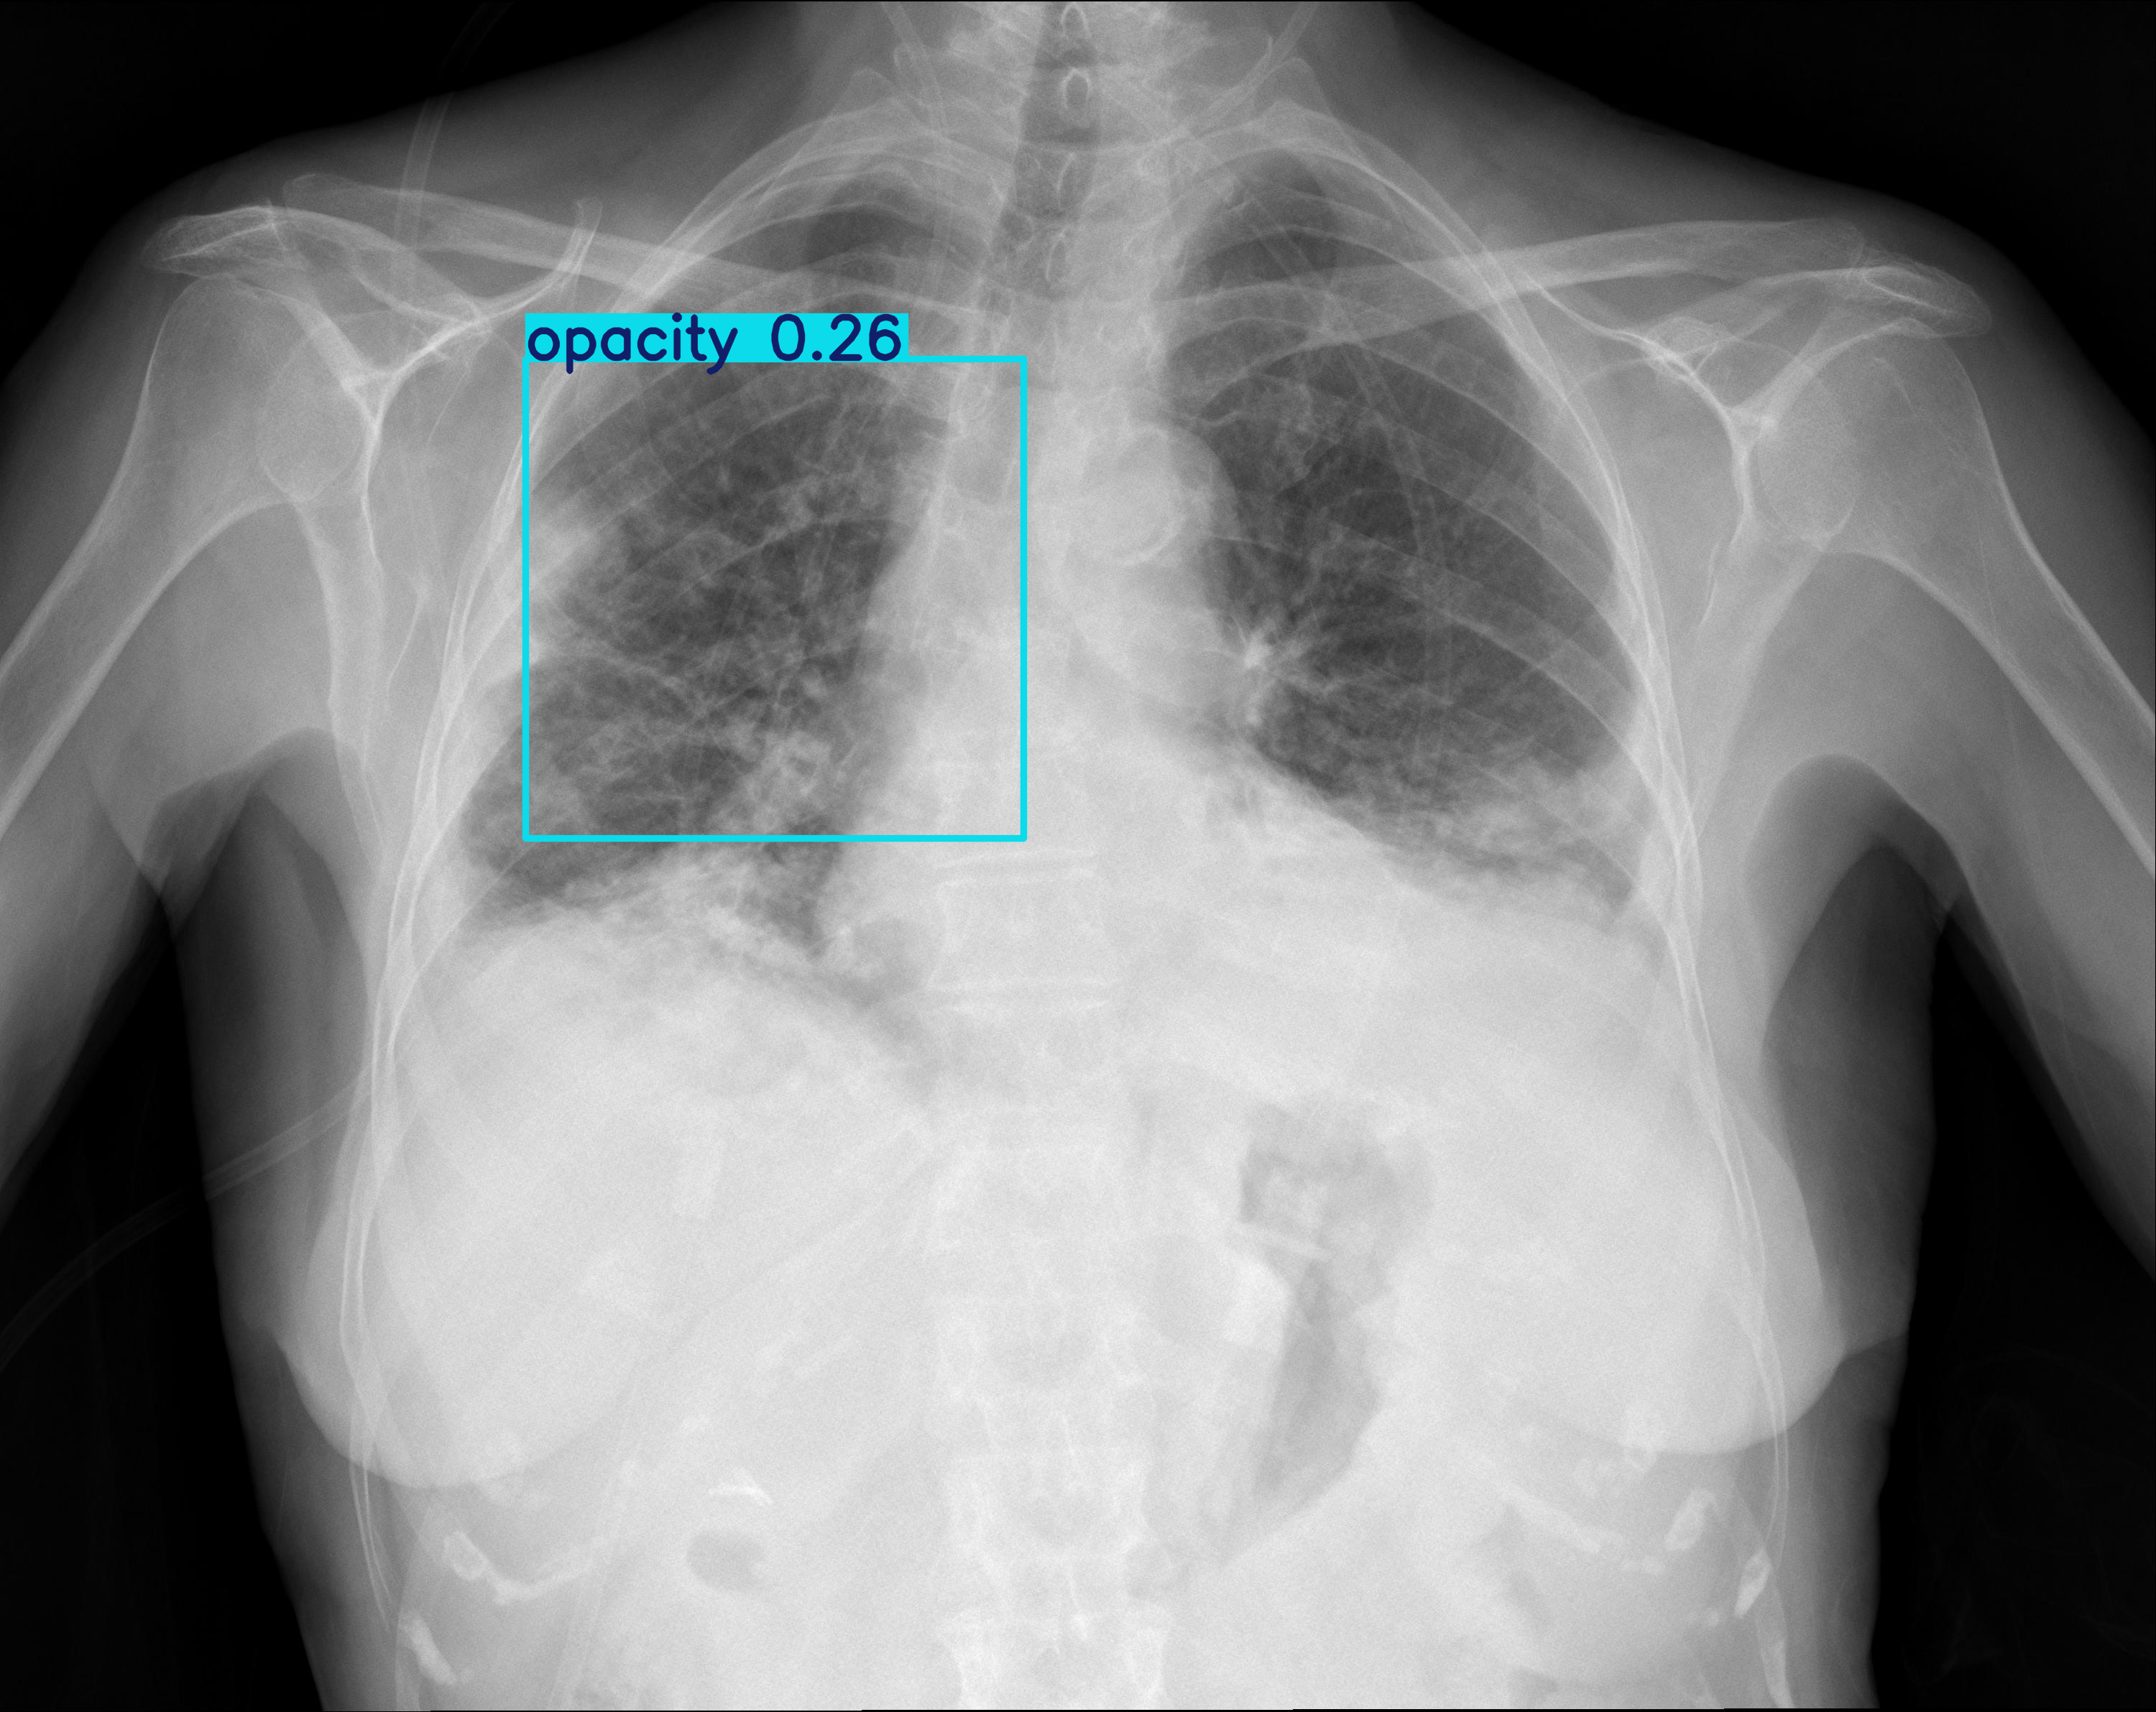

In [26]:
from ultralytics import YOLO
model = YOLO("/kaggle/working/runs/detect/train5/weights/best.pt")
results = model(sample_image_path)
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen